#1 LOAD DATASET

In [ ]:

# We load the three raw Airbnb datasets:
# - calendar.csv  → availability + daily price
# - listings.csv  → static property features
# - reviews.csv   → reviews with timestamps
# These will later be merged into one modeling dataset.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = "/Users/mayidiata/Downloads/"

reviews = pd.read_csv(path+"reviews.csv")
calendar = pd.read_csv(path+"calendar.csv")
listings = pd.read_csv(path+"listings.csv")


In [ ]:
#Clean calendar dataset:
# conver data column. to datetime
calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')

# clean availability t/f → 1/0
calendar['available'] = calendar['available'].map({'t':1, 'f':0})


In [ ]:
# Convert price from string format ("$120.00") into a numeric column.
# This allows us to analyze prices and use them as model features.
calendar['price'] = pd.to_numeric(
    calendar['price'].astype(str).str.replace(r'[\$,]', '', regex=True),
    errors='coerce'
)


In [29]:
# Prepare listings and reviews datasets:
# - Standardize 'listing_id' so all tables can merge correctly
# - Convert review dates to datetime
# - Aggregate reviews per listing (total reviews + most recent review)
listings = listings.rename(columns={'id':'listing_id'})

# convert host dates
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')

# summarize reviews
reviews_summary = reviews.groupby('listing_id').agg(
    num_reviews=('id','count'),
    last_review=('date','max')
).reset_index()


In [30]:
# Merge calendar, listings, and aggregated reviews into a single dataset.
# Each row now represents one listing on one date with all relevant features.
df = calendar.merge(listings, on='listing_id', how='left')
df = df.merge(reviews_summary, on='listing_id', how='left')

print(df.shape)
df.head()


(2863060, 87)


,listing_id,date,available,price_x,adjusted_price,minimum_nights_x,maximum_nights_x,listing_url,scrape_id,last_scraped,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,num_reviews,last_review_y
0,2053439,2025-09-24,f,NaN,NaN,3,30,https://www.airbnb.com/rooms/2053439,20250923203019,2025-09-24,...,4.74,ESFCTU0000460570008730440000000000000CV-VUT004...,f,1,1,0,0,2.19,279.0,2025-09-23
1,2053439,2025-09-25,f,NaN,NaN,3,30,https://www.airbnb.com/rooms/2053439,20250923203019,2025-09-24,...,4.74,ESFCTU0000460570008730440000000000000CV-VUT004...,f,1,1,0,0,2.19,279.0,2025-09-23
2,2053439,2025-09-26,t,NaN,NaN,3,30,https://www.airbnb.com/rooms/2053439,20250923203019,2025-09-24,...,4.74,ESFCTU0000460570008730440000000000000CV-VUT004...,f,1,1,0,0,2.19,279.0,2025-09-23
3,2053439,2025-09-27,f,NaN,NaN,3,30,https://www.airbnb.com/rooms/2053439,20250923203019,2025-09-24,...,4.74,ESFCTU0000460570008730440000000000000CV-VUT004...,f,1,1,0,0,2.19,279.0,2025-09-23
4,2053439,2025-09-28,f,NaN,NaN,3,30,https://www.airbnb.com/rooms/2053439,20250923203019,2025-09-24,...,4.74,ESFCTU0000460570008730440000000000000CV-VUT004...,f,1,1,0,0,2.19,279.0,2025-09-23


In [ ]:
# Compute the percentage of missing values for each column.
# This helps us understand data quality and select reliable modeling features.

df.isna().mean().sort_values(ascending=False).head(20)


price_x                        1.000000
adjusted_price                 1.000000
calendar_updated               1.000000
host_neighbourhood             0.777664
neighborhood_overview          0.582228
neighbourhood                  0.582228
host_about                     0.462392
license                        0.422106
host_location                  0.274987
review_scores_value            0.124681
review_scores_location         0.124681
review_scores_communication    0.124681
review_scores_checkin          0.124681
review_scores_accuracy         0.124681
last_review_y                  0.124554
first_review                   0.124554
review_scores_rating           0.124554
last_review_x                  0.124554
review_scores_cleanliness      0.124554
reviews_per_month              0.124554
dtype: float64

In [14]:
df['available'].value_counts(normalize=True)

available
1    0.50966
0    0.49034
Name: proportion, dtype: float64

In [16]:
[c for c in df.columns if "night" in c.lower()]

['minimum_nights_x',
 'maximum_nights_x',
 'minimum_nights_y',
 'maximum_nights_y',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm']

In [18]:
df['minimum_nights_x'].describe()

count    2.863060e+06
mean     7.633619e+00
std      1.919655e+01
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      1.000000e+01
max      1.111000e+03
Name: minimum_nights_x, dtype: float64

In [20]:
df['maximum_nights_x'].describe()

count    2.863060e+06
mean     5.318021e+02
std      4.525095e+02
min      1.000000e+00
25%      6.500000e+01
50%      3.650000e+02
75%      1.125000e+03
max      1.125000e+03
Name: maximum_nights_x, dtype: float64

In [21]:
df['room_type'].value_counts()

room_type
Entire home/apt    2110430
Private room        743140
Hotel room            5840
Shared room           3650
Name: count, dtype: int64

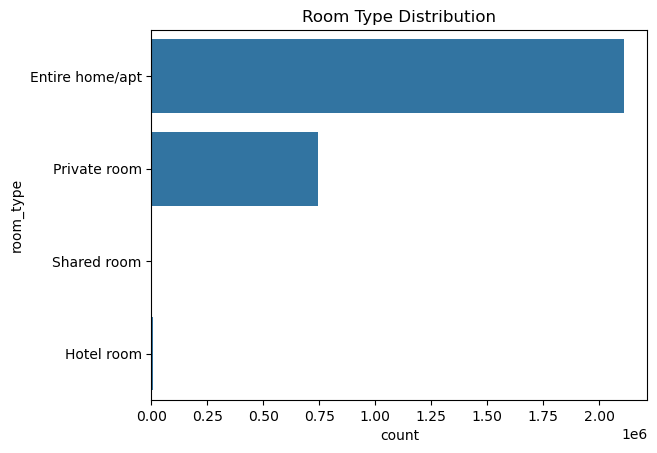

In [24]:
sns.countplot(y='room_type', data=df)
plt.title("Room Type Distribution")
plt.show()


In [25]:
df['num_reviews'].describe()


count    2.506455e+06
mean     5.898209e+01
std      9.055135e+01
min      1.000000e+00
25%      6.000000e+00
50%      2.300000e+01
75%      7.000000e+01
max      9.350000e+02
Name: num_reviews, dtype: float64

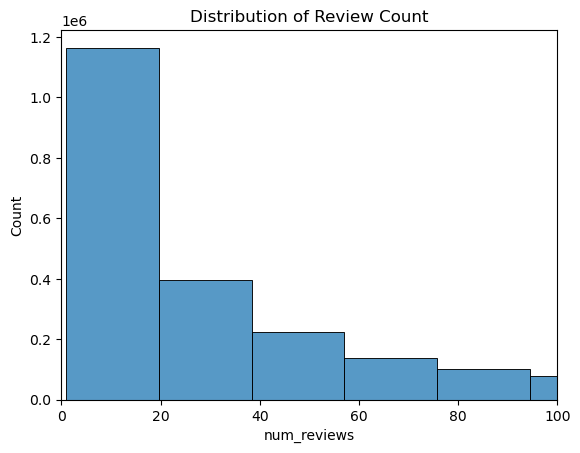

In [26]:
sns.histplot(df['num_reviews'], bins=50)
plt.title("Distribution of Review Count")
plt.xlim(0, 100)  # trim extreme outliers for readability
plt.show()


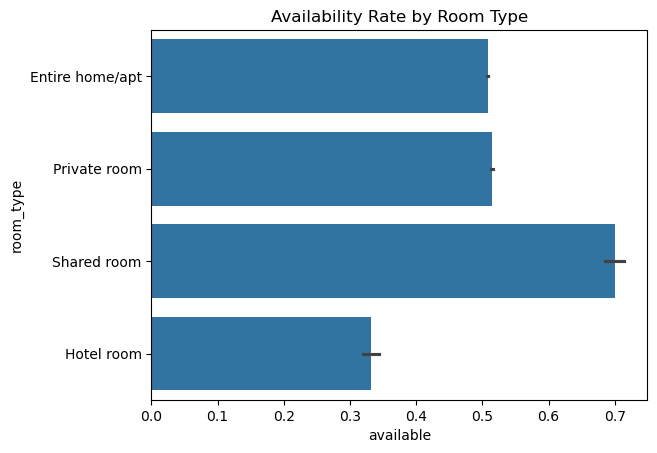

In [27]:
sns.barplot(
    data=df,
    x='available',
    y='room_type',
    estimator=lambda x: sum(x)/len(x)
)
plt.title("Availability Rate by Room Type")
plt.show()


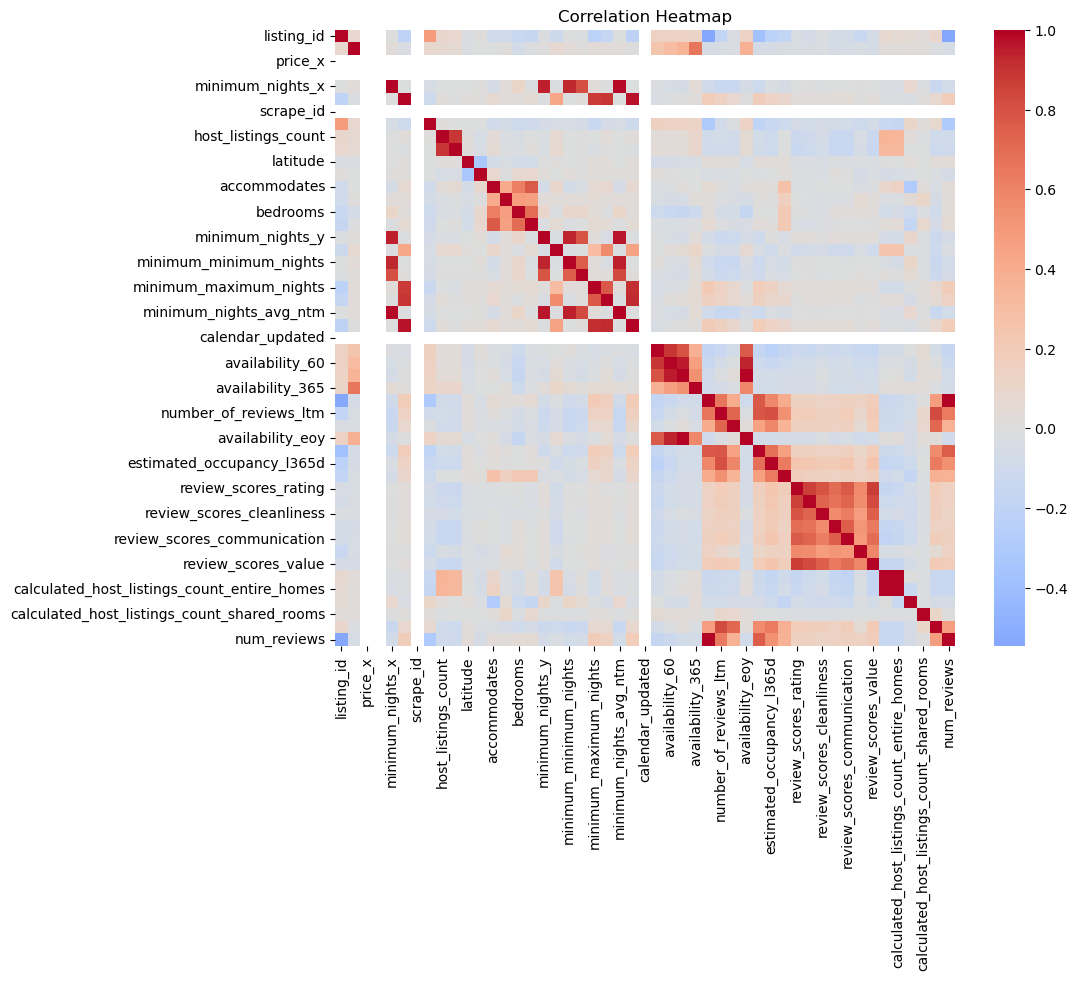

In [28]:
numeric_cols = df.select_dtypes(include='number')
corr = numeric_cols.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()
